In [ ]:
!pip install --upgrade numpy --user

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

C:\Users\user\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\user\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Prepare train/test data

-We already have euclidian distances calculated and saved, we only need to extract the features to feed it into the network

# STEP 1: Get TS Features

In [2]:
import os
import pandas as pd
from natsort import natsorted

partition_train = 'partition1' 

# For flare examples
folder_path = rf'C:\Users\user\Desktop\H01\DATA\{partition_train}\FL'
csv_files = natsorted([file for file in os.listdir(folder_path) if file.endswith('.csv')])
flare_data_list = []
# Loop through the sorted CSV files and load them into dataframes
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    # Use the file name (without extension) as the key in the dictionary
    df = pd.read_csv(file_path, sep='\t')
    first_24_features = df.iloc[:, 1:25]
    flare_data_list.append(first_24_features)
    
# For non-flare examples    
folder_path = rf'C:\Users\user\Desktop\H01\DATA\{partition_train}\NF'
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv') and file.startswith('FQ')]
csv_files = natsorted(csv_files)
non_flare_data_list  = []
# Loop through the sorted CSV files and load them into dataframes
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    # Use the file name (without extension) as the key in the dictionary
    df = pd.read_csv(file_path, sep='\t')
    first_24_features = df.iloc[:, 1:25]
    non_flare_data_list.append(first_24_features)    

In [3]:
# flare
nan_count = 0
indexes_with_nan = []
for index, df in enumerate(flare_data_list):
    if df.isna().any().any():
        if index not in indexes_with_nan:
            nan_count += 1
            indexes_with_nan.append(index)

print("Number of DataFrames with NaN values among flare examples: ", nan_count, "/", len(flare_data_list) )
print("Percentage of DataFrames with NaN values among flare examples: ", (nan_count / len(flare_data_list)) * 100)
print(" ", indexes_with_nan)

# non-flare
nan_count_non_flare = 0
indexes_with_nan_non_flare = []
for index, df in enumerate(non_flare_data_list):
    if df.isna().any().any():
        if index not in indexes_with_nan_non_flare:
            nan_count_non_flare += 1
            indexes_with_nan_non_flare.append(index)

# Calculate the percentage of DataFrames with NaN values among non-flare examples
percentage_with_nan_non_flare = (nan_count_non_flare / len(non_flare_data_list)) * 100

# Report the results
print("Percentage of DataFrames with NaN values among non-flare examples: ", nan_count_non_flare, "/", len(non_flare_data_list) )
print("Percentage of DataFrames with NaN values among non-flare examples: ", (nan_count_non_flare / len(non_flare_data_list)) * 100)
print("Indexes of DataFrames with NaN values among non-flare examples ", indexes_with_nan_non_flare)

flare_data_list = [df for index, df in enumerate(flare_data_list) if index not in indexes_with_nan]
non_flare_data_list = [df for index, df in enumerate(non_flare_data_list) if index not in indexes_with_nan_non_flare]
print(len(flare_data_list))
print(len(non_flare_data_list))

flare_data_list_train = flare_data_list
non_flare_data_list_train = non_flare_data_list

Number of DataFrames with NaN values among flare examples:  74 / 1254
Percentage of DataFrames with NaN values among flare examples:  5.901116427432217
  [43, 46, 47, 48, 49, 50, 51, 52, 54, 263, 264, 273, 346, 463, 472, 513, 525, 555, 659, 734, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 871, 877, 878, 886, 908, 909, 1016, 1042, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1088, 1164, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231]
Percentage of DataFrames with NaN values among non-flare examples:  3811 / 60130
Percentage of DataFrames with NaN values among non-flare examples:  6.33793447530351
Indexes of DataFrames with NaN values among non-flare examples  [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 178, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 2

1180
56319


# test

In [4]:
import os
import pandas as pd
from natsort import natsorted

partition_test = 'partition2' 

# For flare examples
folder_path = rf'C:\Users\user\Desktop\H01\DATA\{partition_test}\FL'
csv_files = natsorted([file for file in os.listdir(folder_path) if file.endswith('.csv')])
flare_data_list = []
# Loop through the sorted CSV files and load them into dataframes
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    # Use the file name (without extension) as the key in the dictionary
    df = pd.read_csv(file_path, sep='\t')
    first_24_features = df.iloc[:, 1:25]
    flare_data_list.append(first_24_features)
    
# For non-flare examples    
folder_path = rf'C:\Users\user\Desktop\H01\DATA\{partition_test}\NF'
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
csv_files = natsorted(csv_files)
non_flare_data_list  = []
# Loop through the sorted CSV files and load them into dataframes
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    # Use the file name (without extension) as the key in the dictionary
    df = pd.read_csv(file_path, sep='\t')
    first_24_features = df.iloc[:, 1:25]
    non_flare_data_list.append(first_24_features)  

In [5]:
# flare
nan_count = 0
indexes_with_nan = []
for index, df in enumerate(flare_data_list):
    if df.isna().any().any():
        if index not in indexes_with_nan:
            nan_count += 1
            indexes_with_nan.append(index)

print("Number of DataFrames with NaN values among flare examples: ", nan_count, "/", len(flare_data_list) )
print("Percentage of DataFrames with NaN values among flare examples: ", (nan_count / len(flare_data_list)) * 100)
print(" ", indexes_with_nan)

# non-flare
nan_count_non_flare = 0
indexes_with_nan_non_flare = []
for index, df in enumerate(non_flare_data_list):
    if df.isna().any().any():
        if index not in indexes_with_nan_non_flare:
            nan_count_non_flare += 1
            indexes_with_nan_non_flare.append(index)

# Calculate the percentage of DataFrames with NaN values among non-flare examples
percentage_with_nan_non_flare = (nan_count_non_flare / len(non_flare_data_list)) * 100

# Report the results
print("Percentage of DataFrames with NaN values among non-flare examples: ", nan_count_non_flare, "/", len(non_flare_data_list) )
print("Percentage of DataFrames with NaN values among non-flare examples: ", (nan_count_non_flare / len(non_flare_data_list)) * 100)
print("Indexes of DataFrames with NaN values among non-flare examples ", indexes_with_nan_non_flare)

flare_data_list = [df for index, df in enumerate(flare_data_list) if index not in indexes_with_nan]
non_flare_data_list = [df for index, df in enumerate(non_flare_data_list) if index not in indexes_with_nan_non_flare]
print(len(flare_data_list))
print(len(non_flare_data_list))

flare_data_list_test = flare_data_list
non_flare_data_list_test = non_flare_data_list

Number of DataFrames with NaN values among flare examples:  116 / 1401
Percentage of DataFrames with NaN values among flare examples:  8.279800142755175
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 133, 214, 255, 264, 266, 304, 305, 313, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 363, 364, 365, 366, 367, 368, 369, 370, 525, 548, 549, 634, 635, 636, 637, 638, 639, 640, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 713, 768, 769, 773, 834, 855, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1176, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1320, 1324, 1325, 1326, 1327, 1328, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366]
Percentage of DataFrames with NaN values among non-flare examples:  8900 / 87156
Percentage of DataFrames with NaN values among non-flare examples:  10.211574647758043
Indexes of DataFrames with NaN values among non-flare examples 

1285
78256


# STEP2: Get Graphs (train and test)

In [6]:
import os
import pickle
import networkx as nx
import numpy as np

partition_train = 'P1'

graph_folder = rf'C:\Users\user\Desktop\H01\DATA\euclidian_distance\graphs_euc_znorm_t0.15_{partition_train}'
graph_list_train = []
labels_train = []

# Iterate through all files in the folder
for filename in os.listdir(graph_folder):
    graph_path = os.path.join(graph_folder, filename)
    try:
        with open(graph_path, 'rb') as f:
            myG = pickle.load(f) # Retrieve graph
        
        # Determine label based on filename
        if filename.startswith('flare'):
            label = 1
        elif filename.startswith('non_flare'):
            label = 0
            
        # Append degrees and label to lists
        graph_list_train.append(myG)
        labels_train.append(label)
    
    except Exception as e:
        print(f"Error processing file {filename}: {str(e)}")

# Convert lists to NumPy arrays
#graph_node_embeddings_list = np.array(graph_node_embeddings_list)
label_vector_train = np.array(labels_train)

# Print or further process the graph_matrix and label_vector as needed
print("Label Vector Train Shape:", label_vector_train.shape)

Label Vector Train Shape: (57499,)


In [7]:
import os
import pickle
import networkx as nx
import numpy as np

partition_test = 'P2'

graph_folder = rf'C:\Users\user\Desktop\H01\DATA\euclidian_distance\graphs_euc_znorm_t0.15_{partition_test}'
graph_list_test = []
labels_test = []

# Iterate through all files in the folder
for filename in os.listdir(graph_folder):
    graph_path = os.path.join(graph_folder, filename)
    try:
        with open(graph_path, 'rb') as f:
            myG = pickle.load(f) # Retrieve graph
        
        # Determine label based on filename
        if filename.startswith('flare'):
            label = 1
        elif filename.startswith('non_flare'):
            label = 0
            
        # Append degrees and label to lists
        graph_list_test.append(myG)
        labels_test.append(label)
    
    except Exception as e:
        print(f"Error processing file {filename}: {str(e)}")

# Convert lists to NumPy arrays
#graph_node_embeddings_list = np.array(graph_node_embeddings_list)
label_vector_test = np.array(labels_test)

#print("Graph Matrix Shape:", graph_list.shape)
print("Label Vector Test Shape:", label_vector_test.shape)

Label Vector Test Shape: (79541,)


# Creating the custom dataset

In [46]:
from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, graph_list, ts_list, labels):
        self.graph_list = graph_list
        self.ts_list = ts_list
        self.labels = labels

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, idx):
        graph = self.graph_list[idx]
        ts = self.ts_list[idx]
        label = self.labels[idx]
        
        # For edges, we need to account for both directions of an edge
        node_mapping = {node: i for i, node in enumerate(graph.nodes())}
        edges = list(graph.edges())
        all_edges = [(node_mapping[edge[0]], node_mapping[edge[1]]) for edge in edges]
        all_edges += [(edge[1], edge[0]) for edge in all_edges]
        edge_index = torch.tensor(all_edges, dtype=torch.long).t().contiguous()
        
        data = Data(x=torch.tensor(ts, dtype=torch.float).t(),
                    edge_index=edge_index,
                    y=torch.tensor(label, dtype=torch.float))
        
        return data

# Create custom dataset format

In [47]:
import numpy as np

# Combine TS flare and nonflare
combined_ts_list_train = np.concatenate([flare_data_list_train, non_flare_data_list_train], axis=0)
combined_ts_list_test = np.concatenate([flare_data_list_test, non_flare_data_list_test], axis=0)

# Create data loaders
train_dataset = CustomDataset(graph_list_train, combined_ts_list_train, label_vector_train)
test_dataset = CustomDataset(graph_list_test, combined_ts_list_test, label_vector_test)


# GCN 

In [92]:
# Define 2 layer gcn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx
import networkx as nx
import numpy as np
from torch_geometric.nn import global_mean_pool

# Define the GCN model with a fully connected layer
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.fc = nn.Linear(out_channels, 1)  # FC for 0-1 classification

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        #print("x.shape ", x.shape)
        #print("edge_index.shape ", edge_index.shape)
      
        #print("X before conv 1", x.shape)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        #print("X after conv 2, before pooling", x.shape)
        
        x = x.view(data.num_graphs, int(x.shape[0]/data.num_graphs), x.shape[1])
        x = torch.mean(x, dim=1)
        #x = global_mean_pool(x, batch)
        
        #print("X after pooling, before fc ", x.shape)
        x = self.fc(x)
        #print("X after fc ", x.shape)
        return torch.sigmoid(x) 

# Train GCN

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch_geometric.data import Batch

def custom_collate(batch):
    # Use the Batch class from torch_geometric to handle variable-size graphs
    return Batch.from_data_list(batch)

# Create DataLoader instances withcustom collate function
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=custom_collate)

# Initialize GCN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=60, hidden_channels=64, out_channels=32).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_losses = []
train_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        data = batch.to(device) 
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y.view(-1, 1).float())
        loss.backward()
        optimizer.step()

        # Update metrics
        total_loss += loss.item()
        total_samples += data.num_graphs
        predicted_labels = (output >= 0.5).float()  # Threshold of 0.5 for binary classification
        #print(predicted_labels, "----", data.y.view(-1, 1))
        correct_predictions += (predicted_labels == data.y.view(-1, 1)).sum().item()
        #print("CORRECT PRED ",correct_predictions, "OUT OF", total_samples)
        
    average_loss_epoch = total_loss / total_samples
    accuracy_epoch = correct_predictions / total_samples
    
    train_losses.append(average_loss_epoch)
    train_accuracies.append(accuracy_epoch)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss_epoch:.4f}, Accuracy: {accuracy_epoch:.4f}')


GCN(
  (conv1): GCNConv(60, 64)
  (conv2): GCNConv(64, 32)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


Epoch 1/20: 100%|██████████| 899/899 [00:21<00:00, 42.51it/s]


Epoch 1/20, Loss: 0.2630, Accuracy: 0.8317


Epoch 2/20: 100%|██████████| 899/899 [00:20<00:00, 42.98it/s]


Epoch 2/20, Loss: 0.2661, Accuracy: 0.8298


Epoch 3/20: 100%|██████████| 899/899 [00:20<00:00, 42.82it/s]


Epoch 3/20, Loss: 0.2643, Accuracy: 0.8309


Epoch 4/20: 100%|██████████| 899/899 [00:20<00:00, 42.84it/s]


Epoch 4/20, Loss: 0.2605, Accuracy: 0.8334


Epoch 5/20: 100%|██████████| 899/899 [00:20<00:00, 42.85it/s]


Epoch 5/20, Loss: 0.2624, Accuracy: 0.8321


Epoch 6/20: 100%|██████████| 899/899 [00:20<00:00, 43.19it/s]


Epoch 6/20, Loss: 0.2618, Accuracy: 0.8325


Epoch 7/20: 100%|██████████| 899/899 [00:20<00:00, 42.98it/s]


Epoch 7/20, Loss: 0.2627, Accuracy: 0.8320


Epoch 8/20: 100%|██████████| 899/899 [00:20<00:00, 43.38it/s]


Epoch 8/20, Loss: 0.2681, Accuracy: 0.8285


Epoch 9/20: 100%|██████████| 899/899 [00:24<00:00, 36.17it/s]


Epoch 9/20, Loss: 0.2666, Accuracy: 0.8295


Epoch 10/20: 100%|██████████| 899/899 [00:21<00:00, 42.33it/s]


Epoch 10/20, Loss: 0.2653, Accuracy: 0.8303


Epoch 11/20: 100%|██████████| 899/899 [00:20<00:00, 43.07it/s]


Epoch 11/20, Loss: 0.2651, Accuracy: 0.8304


Epoch 12/20: 100%|██████████| 899/899 [00:21<00:00, 42.17it/s]


Epoch 12/20, Loss: 0.2689, Accuracy: 0.8281


Epoch 13/20: 100%|██████████| 899/899 [00:21<00:00, 42.58it/s]


Epoch 13/20, Loss: 0.2665, Accuracy: 0.8295


Epoch 14/20: 100%|██████████| 899/899 [00:21<00:00, 42.58it/s]


Epoch 14/20, Loss: 0.2649, Accuracy: 0.8306


Epoch 15/20: 100%|██████████| 899/899 [00:21<00:00, 42.32it/s]


Epoch 15/20, Loss: 0.2650, Accuracy: 0.8305


Epoch 16/20: 100%|██████████| 899/899 [00:21<00:00, 42.35it/s]


Epoch 16/20, Loss: 0.2656, Accuracy: 0.8300


Epoch 17/20: 100%|██████████| 899/899 [00:21<00:00, 42.59it/s]


Epoch 17/20, Loss: 0.2653, Accuracy: 0.8304


Epoch 18/20: 100%|██████████| 899/899 [00:21<00:00, 42.14it/s]


Epoch 18/20, Loss: 0.2625, Accuracy: 0.8321


Epoch 19/20: 100%|██████████| 899/899 [00:20<00:00, 42.87it/s]


Epoch 19/20, Loss: 0.2676, Accuracy: 0.8288


Epoch 20/20: 100%|██████████| 899/899 [00:23<00:00, 38.28it/s]

Epoch 20/20, Loss: 0.2660, Accuracy: 0.8299


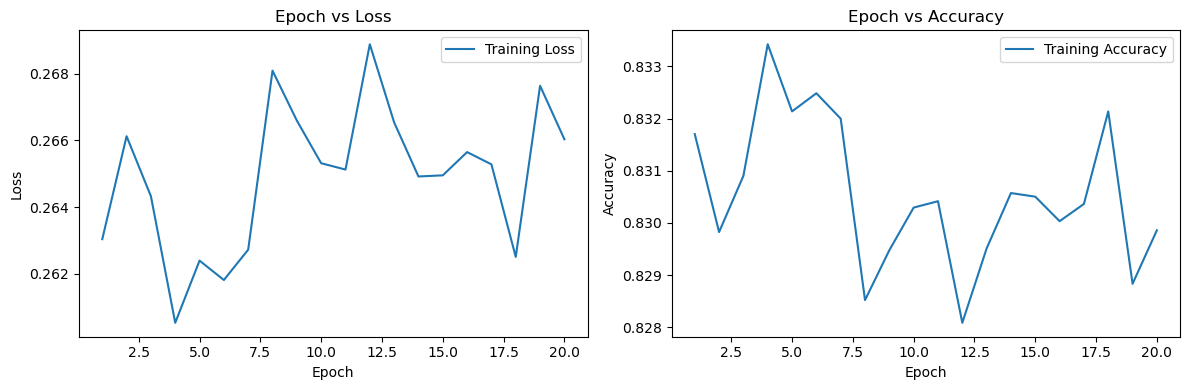

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# TEST GCN

In [100]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Evaluate on the test set
model.eval()
true_labels, predicted_labels = [], []

with torch.no_grad():
    for data in tqdm(test_loader, desc='Testing'):
        data = data.to(device)
        output = (model(data) >= 0.5).float()
        true_labels.extend(data.y.cpu().numpy())
        predicted_labels.extend(output.cpu().numpy())

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate True Skill Statistics (TSS)
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Calculate Heidke Skill Score 1 (HSS1)
hss1 = (tp / (tp + fn)) * (2 - (tp + fp) / tp)

# Calculate Heidke Skill Score 2 (HSS2)
hss2 = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (tn + fn) + (tp + fp) * (tn + fp))

# Calculate F1 Score
f1 = f1_score(true_labels, predicted_labels)

# Calculate Gilbert Skill Score
gilbert = (tp - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)) / (
        tp + tn - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)
)

# Calculate ROC AUC score
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Print the results
print("GCN Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("True Skill Statistics (TSS):", tss)
print("Heidke Skill Score 1 (HSS1):", hss1)
print("Heidke Skill Score 2 (HSS2):", hss2)
print("F1 Score:", f1)
print("Gilbert Skill Score:", gilbert)
print("ROC AUC Score:", roc_auc)

Testing: 100%|██████████| 1243/1243 [00:44<00:00, 27.79it/s]


GCN Model Evaluation Metrics:
Accuracy: 0.9111653109717002
True Skill Statistics (TSS): -0.05473714127512855
Heidke Skill Score 1 (HSS1): -4.498832684824903
Heidke Skill Score 2 (HSS2): -0.019978328291600005
F1 Score: 0.007026419336706015
Gilbert Skill Score: -0.0009560673013602484
ROC AUC Score: 0.4726314293624357
